In [1]:
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds


2023-01-12 10:35:28.338453: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
import tensorflow_addons as tfa

In [3]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()        

In [4]:
# image cropped, rescaled to 48x48 already

CK_PATH="CK_PLUS/CK+48" 
CK_PATH= pathlib.Path(CK_PATH)
image_count = len(list(CK_PATH.glob('*/*.png')))
#print(image_count)

In [5]:
anger = list(CK_PATH.glob('anger/*'))
contempt = list(CK_PATH.glob('contempt/*'))
disgust = list(CK_PATH.glob('disgust/*'))
fear = list(CK_PATH.glob('fear/*'))
happy = list(CK_PATH.glob('happy/*'))
sadness = list(CK_PATH.glob('sadness/*'))
surprise = list(CK_PATH.glob('surprise/*'))
#PIL.Image.open(str(happy[0]))
#print image

In [6]:
batch_size=32 #test
img_height = 48
img_width = 48

In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(
CK_PATH,
labels='inferred',
label_mode='int',
validation_split=0.15,
subset="training",
seed=100,
image_size=(img_height, img_width),
batch_size=batch_size)

test_ds = tf.keras.utils.image_dataset_from_directory(
CK_PATH,
labels='inferred',
label_mode='int',
validation_split=0.15,
subset="validation",
seed=100,
image_size=(img_height, img_width),
batch_size=batch_size)


Found 981 files belonging to 7 classes.
Using 834 files for training.
Found 981 files belonging to 7 classes.
Using 147 files for validation.


In [24]:
class_names = train_ds.class_names
class_no = len(class_names)
#print(class_names )

['anger', 'contempt', 'disgust', 'fear', 'happy', 'sadness', 'surprise']


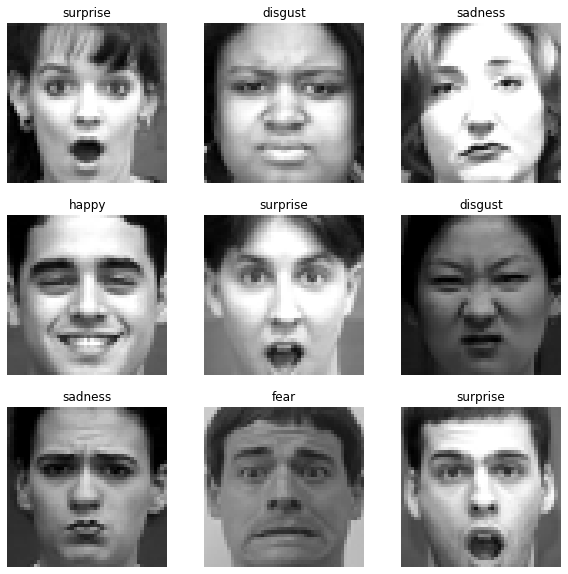

In [91]:
"""
plt.figure(figsize=(10, 10)) #first 9 image with class
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
        
"""

In [10]:
for image_batch, labels_batch in train_ds:
    input_shape = image_batch.shape
    label_shape = labels_batch.shape
    print(input_shape)
    #print(label_shape )
    break 

(32, 48, 48, 3)


2023-01-12 10:35:51.560285: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [95]:
image_batch = image_batch.reshape(batch_size, img_height, img_width, 3)
image_batch = image_batch.astype('float32')

In [73]:
def rotation(image,angle):
    rot_image = tfa.image.rotate(image, angle, interpolation = 'nearest')

    return rot_image
    

#5 degrees of rotation at a step of 0.1 degrees
def rotation_list(image):

    angles_rad = []
    image_list=[]
    for i in range(1,51):
        angles_rad +=[0.1*i* np.pi / 180] 

        image_list +=[ rotation(image,angles_rad[i-1])]
    return image_list

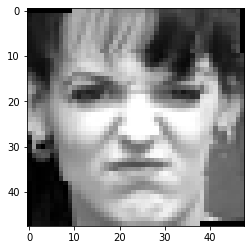

In [78]:
#plt.imshow(rotation_list(image_batch[0])[20])

In [91]:
aut_train_ds = train_ds.map(lambda x, y: (rotation_list(x), y))
aut_test_ds = test_ds.map(lambda x, y: (rotation_list(x), y))

In [92]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE) #no rotation
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)


aut_train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
aut_test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [93]:
#FIRST PROPOSED MODEL
#-------------------
model = keras.Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1.0 / 255)) #normalization

#--convolutional layer x3---
model.add(tf.keras.layers.Conv2D(6, kernel_size=(3, 3),padding='same',  activation='relu', input_shape=(image_batch.shape[1], image_batch.shape[2], 3) ))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=(image_batch.shape[1], image_batch.shape[2], 3) ))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

model.add(tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=(image_batch.shape[1], image_batch.shape[2], 3) ))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

#--Fully Connected Layers x2---

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256,activation=None))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(128,activation=None))
model.add(tf.keras.layers.Dropout(0.5))

#--

model.add(tf.keras.layers.Dense(class_no, activation='softmax'))


#-------------------

In [94]:
model.build(input_shape)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (32, 48, 48, 3)           0         
                                                                 
 conv2d_3 (Conv2D)           (32, 48, 48, 6)           168       
                                                                 
 batch_normalization_3 (Batc  (32, 48, 48, 6)          24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_3 (MaxPooling  (32, 24, 24, 6)          0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (32, 22, 22, 16)          880       
                                                                 
 batch_normalization_4 (Batc  (32, 22, 22, 16)        

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [16]:
history= model.fit(train_ds, batch_size=7, epochs=20,verbose=1,validation_data = test_ds)


Epoch 1/20
27/27 [==============================] - 1s 32ms/step - loss: 0.0462 - accuracy: 0.9868 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 2/20
27/27 [==============================] - 1s 29ms/step - loss: 0.0280 - accuracy: 0.9904 - val_loss: 0.0154 - val_accuracy: 0.9932
Epoch 3/20
27/27 [==============================] - 1s 29ms/step - loss: 0.0232 - accuracy: 0.9904 - val_loss: 0.0068 - val_accuracy: 1.0000
Epoch 4/20
27/27 [==============================] - 1s 28ms/step - loss: 0.0194 - accuracy: 0.9928 - val_loss: 0.0267 - val_accuracy: 0.9932
Epoch 5/20
27/27 [==============================] - 1s 28ms/step - loss: 0.0381 - accuracy: 0.9856 - val_loss: 0.0664 - val_accuracy: 0.9728
Epoch 6/20
27/27 [==============================] - 1s 28ms/step - loss: 0.0276 - accuracy: 0.9940 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 7/20
27/27 [==============================] - 1s 28ms/step - loss: 0.0165 - accuracy: 0.9928 - val_loss: 0.0763 - val_accuracy: 0.9796
Epoch 8/20
27

In [18]:
history_dict = history.history
#print(history_dict.keys())

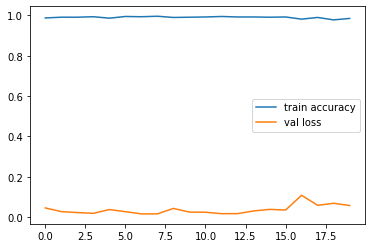

In [19]:
plt.plot(history_dict['accuracy'], label='train accuracy')
plt.plot(history_dict['loss'], label='val loss')
plt.legend()
plt.show()